In [1]:
from scipy.io import loadmat
from scipy.stats import circmean, circstd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

from utils import validate_data

## Loading all the data

In [2]:
# Set in stone
data_path = './axej_eeg/'
n_subjects = 13
n_sessions = 4
n_runs = 6
n_trials = 120
n_ts = 500

exp_ts = 1000

# noise frames = 0 to 220 (250 - 30)
noise_thresh = 0.5
noise_gap = 30


experiment_orientations = [159, 123, 87, 51, 15]
subjects = ["01", "02", "03", "04", "05", "06", "07", "08" ,"09", "10", "11", "12", "13"]
subjects_name = ["01", "02", "03", "04", "05", "06", "07", "08" ,"09", "10", "11", "12", "14"]

def get_calib(subj, sess):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects_name[subj]}_S{sess+1}_Cali1.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

def get_run(subj, sess, run):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects_name[subj]}_S{sess+1}_Run{run+1}.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

In [3]:
# Get all run data
# subjexts x sessions x runs
jx = []
jy = []
stimdir = []
tgonset = []

# Attention (attCue): tr_foc = 1, tr_div = 2
# Coherence (tgCoh): tr_lo = 1, tr_hi = 2
att = []
coh = []

for subj in tqdm(range(n_subjects)):
    for sess in range(n_sessions):
        for run in range(n_runs):

            data = get_run(subj, sess, run)
            jx.append(data["joyx"])
            jy.append(data["joyy"])
            stimdir.append(data["stimDirREAL"])

            f_tgonset = data["f_precuedur"] + data["f_cuedur"]
            tgonset.append(f_tgonset)

            att.append(data["attCue"])
            coh.append(data["tgCoh"])

# Shape the run data
jx = np.array(jx, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)
jy = np.array(jy, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)
stimdir = np.array(stimdir).reshape(n_subjects, n_sessions, n_runs, n_trials)
tgonset = np.array(tgonset).reshape(n_subjects, n_sessions, n_runs, n_trials)
att = np.array(att).reshape(n_subjects, n_sessions, n_runs, n_trials)
coh = np.array(coh).reshape(n_subjects, n_sessions, n_runs, n_trials)

jx.shape, jy.shape, stimdir.shape, tgonset.shape

100%|██████████| 13/13 [00:00<00:00, 13.42it/s]


((13, 4, 6, 120, 500), (13, 4, 6, 120, 500), (13, 4, 6, 120), (13, 4, 6, 120))

## Logic for Getting Valid Trials:

1. Get all the trials
2. Align all target onset at 250 ts
3. Get distance from center and angle from center
4. If the distance moves <0.4 au n frames before target onset. Then that trial is "too early" and all response set nan.
5. If ts has distance > 1 au then set its response angle to the last valid angle (if first, the nan) and set that distance to 1.
6. get angle first distance = 1 a.u. instance after target onset. or if it never reaches 1, then angle at max distance after target onset. as the response angle.

In [4]:
shifted_jx, shifted_jy, dist_from_cent, resp_angle, final_resp_angles, final_resp_idx = validate_data(n_subjects, n_sessions, n_runs, n_trials, n_ts, exp_ts, jx, jy, tgonset, noise_thresh, noise_gap)

In [5]:
# Get all trials where angles are only nan
nan_trials = np.where(np.isnan(resp_angle).all(axis=-1))
print(nan_trials[0].shape[0], "invalid trials")
print(nan_trials[0].shape[0] / (n_subjects * n_sessions * n_runs * n_trials) * 100, "% invalid trials")

2919 invalid trials
7.7964743589743595 % invalid trials


## Circular stat defs

In [6]:
def circdist(a, b):
    return min(abs(a-b), 360-abs(a-b))

def circmedian(angs):
    angs = np.array(angs)
    angs = angs[~np.isnan(angs)]
    pdists = angs[np.newaxis, :] - angs[:, np.newaxis]
    pdists = (pdists + 180) % (2 * 180) - 180
    pdists = np.abs(pdists).sum(1)
    return angs[np.argmin(pdists)]

In [7]:
calib_median = np.load("circ_median.npy")
median_key = {15:0, 51:1, 87:2, 123:3, 159:4}

In [8]:
calib_std = np.load("circ_std.npy")
std_key = {15:0, 51:1, 87:2, 123:3, 159:4}

## Seperating by accuracy

In [9]:
final_resp_angles.shape, stimdir.shape

((13, 4, 6, 120), (13, 4, 6, 120))

In [10]:
# One and two sigma distance from the calibration median

resp_correct_sigma = np.zeros_like(final_resp_angles)
resp_correct_sigma[:] = np.nan

resp_correct_two_sigma = np.zeros_like(final_resp_angles)
resp_correct_two_sigma[:] = np.nan

targ_calib = np.zeros_like(final_resp_angles)
targ_calib[:] = np.nan

for subj in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                actual_stimdir = stimdir[subj,sess,run,trial]

                # Get the median and std for the actual stimdir
                calib_resp_median = calib_median[subj,median_key[actual_stimdir]]
                calib_resp_sigma = calib_std[subj,std_key[actual_stimdir]]

                # Get the response angle
                trial_response = final_resp_angles[subj,sess,run,trial]

                # Skip if the trial is 'too early'
                if np.isnan(trial_response): continue

                targ_calib[subj,sess,run,trial] = calib_resp_median

                # Check if the response is within 1 sigma or 2 sigma
                resp_correct_sigma[subj,sess,run,trial] = circdist(calib_resp_median, trial_response) <= calib_resp_sigma
                resp_correct_two_sigma[subj,sess,run,trial] = circdist(calib_resp_median, trial_response) <= calib_resp_sigma*2


In [11]:
resp_df = pd.DataFrame({
    "subj": np.repeat(np.arange(n_subjects), n_sessions*n_runs*n_trials),
    "sess": np.tile(np.repeat(np.arange(n_sessions), n_runs*n_trials), n_subjects),
    "run": np.tile(np.repeat(np.arange(n_runs), n_trials), n_subjects*n_sessions),
    "trial": np.tile(np.arange(n_trials), n_subjects*n_sessions*n_runs),
    "target": stimdir.flatten(),
    "targ_calib": targ_calib.flatten(),
    "resp": final_resp_angles.flatten(),
    "one_sigma": resp_correct_sigma.flatten(),
    "two_sigma": resp_correct_two_sigma.flatten()
})
resp_df.dropna(inplace=True)
resp_df

subj  sess  run  trial  target  targ_calib        resp  one_sigma  \
0         0     0    0      0     159  145.877462  150.877772        1.0   
1         0     0    0      1     123  138.718044  127.920427        1.0   
2         0     0    0      2      51   32.872185  131.003103        0.0   
3         0     0    0      3     159  145.877462  144.775174        1.0   
4         0     0    0      4      15   18.752776  142.791565        0.0   
...     ...   ...  ...    ...     ...         ...         ...        ...   
37435    12     3    5    115      51   37.048176  160.967904        0.0   
37436    12     3    5    116      15    2.591583   37.650337        0.0   
37437    12     3    5    117     159  151.890213   85.831991        0.0   
37438    12     3    5    118     123  137.879638  154.102492        0.0   
37439    12     3    5    119      51   37.048176   33.039186        1.0   

       two_sigma  
0            1.0  
1            1.0  
2            0.0  
3            1.0  
4            0.0  
...          ...  
37435        0.0  
37436        0.0  
37437        0.0  
37438        1.0  
37439        1.0  

[34521 rows x 9 columns]

In [12]:
correct_one_sigma_trials = resp_df[resp_df["one_sigma"] == True]
incorrect_one_sigma_trials = resp_df[resp_df["one_sigma"] == False]

correct_two_sigma_trials = resp_df[resp_df["two_sigma"] == True]
incorrect_two_sigma_trials = resp_df[resp_df["two_sigma"] == False]

In [13]:
total_len = correct_two_sigma_trials.shape[0] + incorrect_two_sigma_trials.shape[0]
total_len

34521

In [14]:
correct_two_sigma_trials.shape[0]/ total_len * 100 , incorrect_two_sigma_trials.shape[0]/ total_len * 100

(44.95524463370123, 55.04475536629877)

In [15]:
correct_two_sigma_trials

subj  sess  run  trial  target  targ_calib        resp  one_sigma  \
0         0     0    0      0     159  145.877462  150.877772        1.0   
1         0     0    0      1     123  138.718044  127.920427        1.0   
3         0     0    0      3     159  145.877462  144.775174        1.0   
5         0     0    0      5     159  145.877462  140.697354        1.0   
10        0     0    0     10     159  145.877462  140.992527        1.0   
...     ...   ...  ...    ...     ...         ...         ...        ...   
37426    12     3    5    106     159  151.890213  162.405278        0.0   
37427    12     3    5    107      87   89.645622   87.417241        1.0   
37430    12     3    5    110      51   37.048176   41.034018        1.0   
37438    12     3    5    118     123  137.879638  154.102492        0.0   
37439    12     3    5    119      51   37.048176   33.039186        1.0   

       two_sigma  
0            1.0  
1            1.0  
3            1.0  
5            1.0  
10           1.0  
...          ...  
37426        1.0  
37427        1.0  
37430        1.0  
37438        1.0  
37439        1.0  

[15519 rows x 9 columns]

## GLM

In [16]:
import pymc as pm
import arviz as az
az.style.use("arviz-doc")

In [17]:
def fit_glm(data_from):

    # Convert y to radians if needed, since von Mises requires radians
    x = np.radians(data_from["targ_calib"].values) - np.pi
    y = np.radians(data_from["resp"].values) - np.pi

    with pm.Model() as model:
        # Priors for the intercept and slope
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        slope = pm.Normal("slope", mu=0, sigma=1)
        kappa = pm.HalfNormal("kappa", sigma=1)

        # Regression equation for the angle
        mu = intercept + slope * x

        # Define the von Mises likelihood
        # y_obs = pm.Normal("y_obs", mu=mu, sigma=kappa, observed=y)
        y_obs = pm.VonMises("y_obs", mu=mu, kappa=kappa, observed=y)

        # Sample from the posterior
        trace = pm.sample(chains=4, tune=1000, draws=1000)

    return x, y, trace

In [35]:
c_x, c_y, correct_trace = fit_glm(correct_two_sigma_trials)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, kappa]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [19]:
i_x, i_y, incorrect_trace = fit_glm(incorrect_two_sigma_trials)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, kappa]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


/tmp/ipykernel_3211582/93059221.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


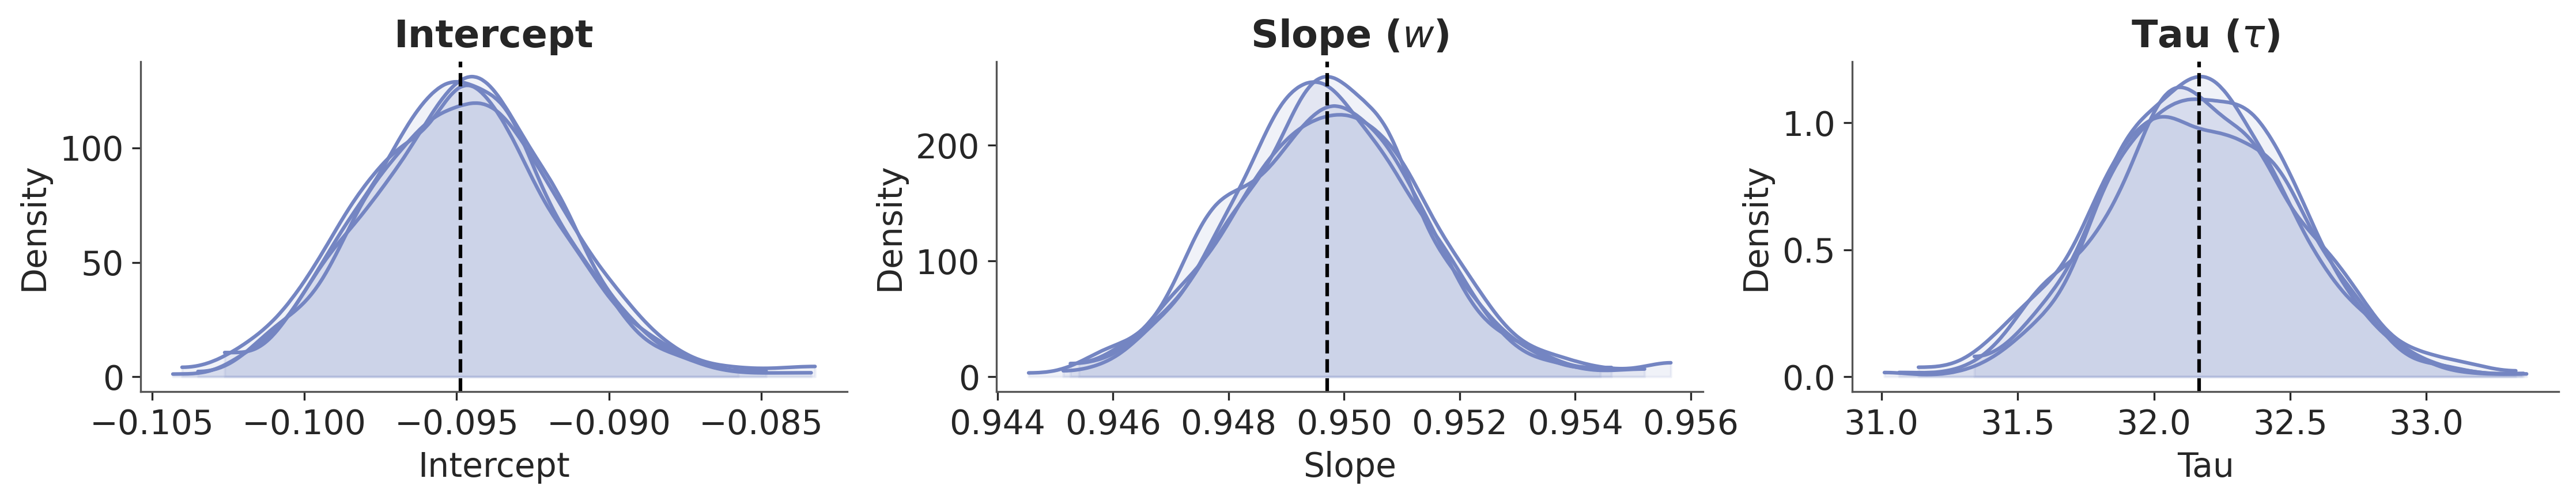

In [36]:
variables = ["intercept", "slope", "kappa"]
titles = ["Intercept", "Slope ($w$)", "Tau ($\\tau$)"]
x_labels = ["Intercept", "Slope", "Tau"]

fig, ax = plt.subplots(1, 3, figsize=(15, 3), dpi=300)
for i, var in enumerate(variables):

    data = correct_trace.posterior[var].values
    
    for j in range(4):
        az.plot_dist(data[j], color="#7485C2", fill_kwargs={"alpha": 0.1}, ax=ax[i])

    # plot a center mean line
    ax[i].axvline(data.mean(), color="k", linestyle="--")

    ax[i].set_xlabel(x_labels[i])
    ax[i].set_ylabel("Density")
    ax[i].set_title(titles[i])

plt.tight_layout()


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

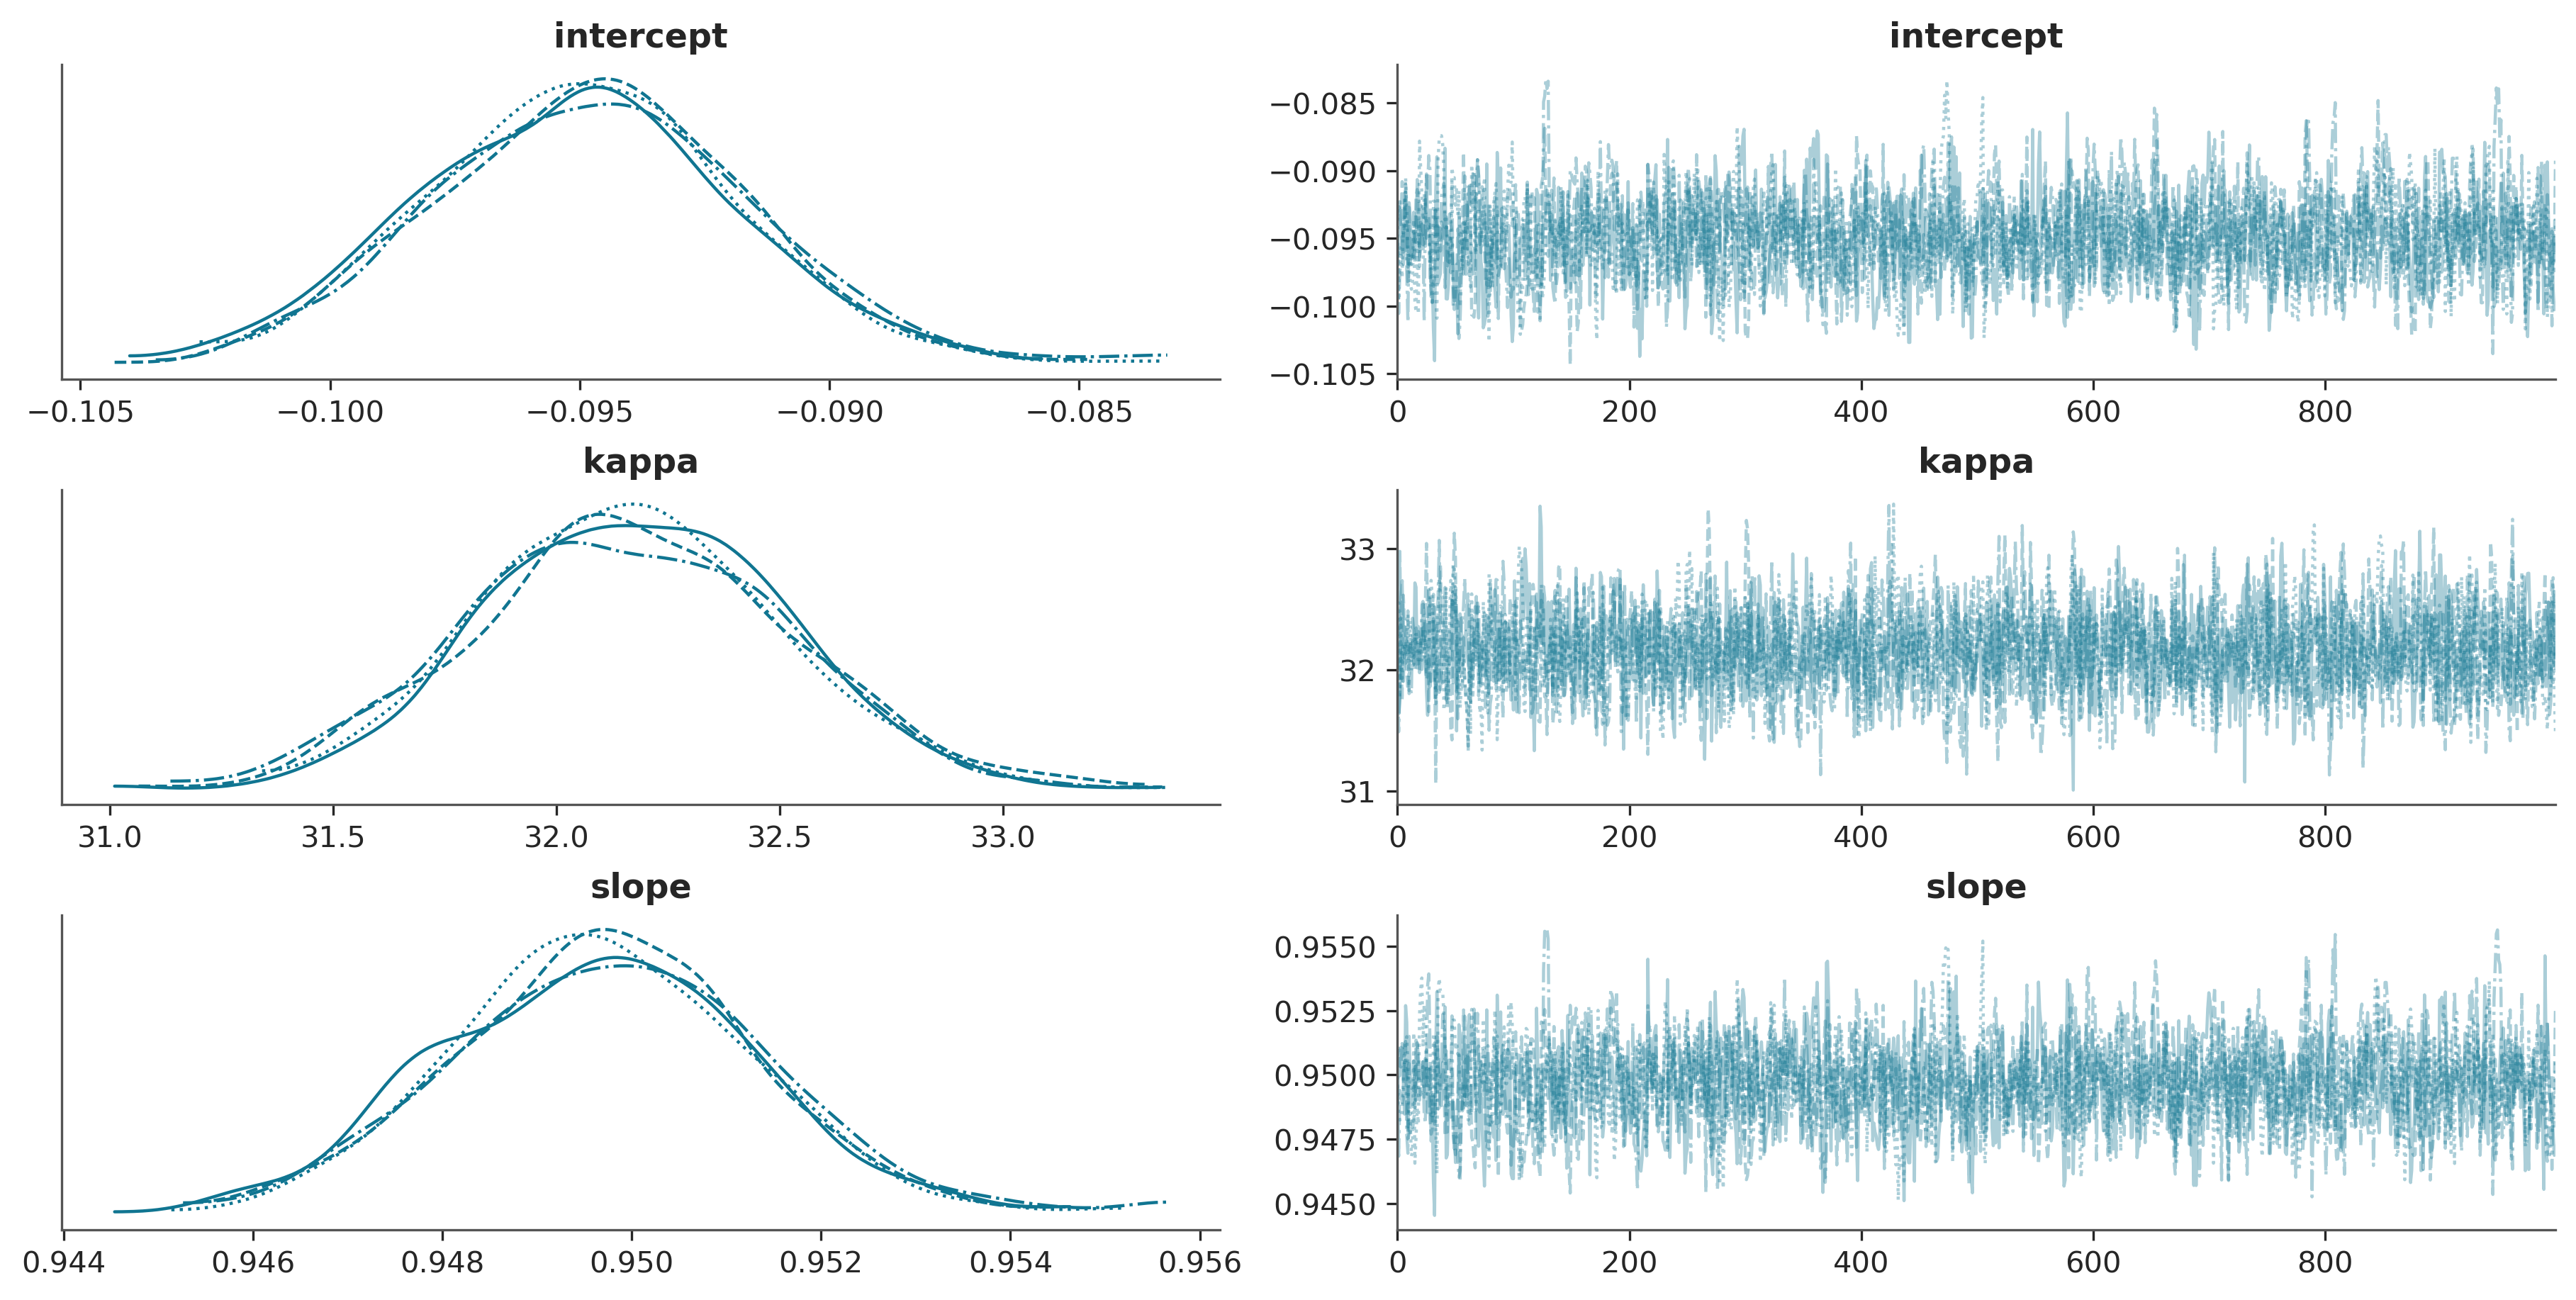

In [37]:
az.plot_trace(correct_trace)
correct_trace

In [38]:
az.summary(correct_trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  -0.095  0.003  -0.101   -0.089      0.000    0.000    1606.0   
kappa      32.166  0.343  31.542   32.806      0.007    0.005    2312.0   
slope       0.950  0.002   0.947    0.953      0.000    0.000    1704.0   

           ess_tail  r_hat  
intercept    1632.0    1.0  
kappa        2550.0    1.0  
slope        1759.0    1.0

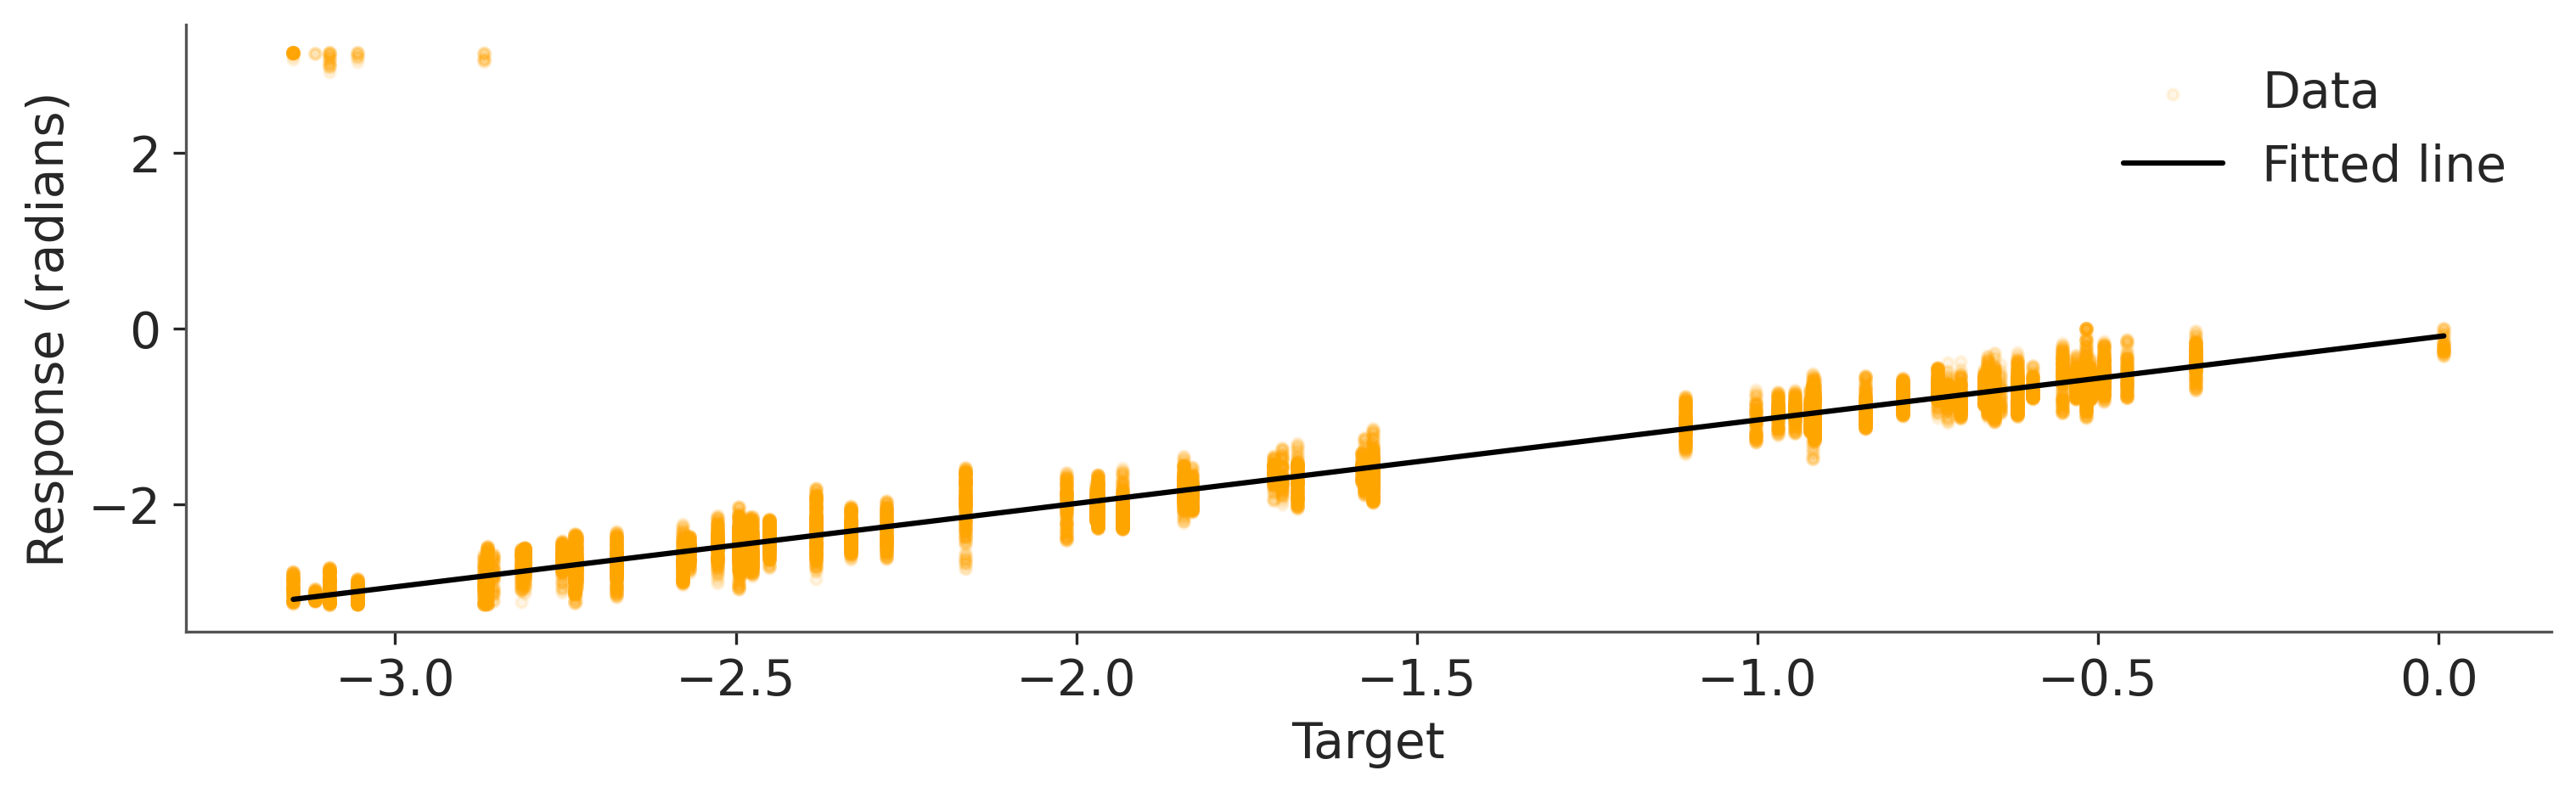

In [39]:
x = c_x
y = c_y

x_values = np.linspace(x.min(), x.max(), 100)
y_values = correct_trace.posterior["intercept"].mean().values + correct_trace.posterior["slope"].mean().values * x_values

plt.figure(figsize=(10, 3), dpi=300)
plt.scatter(x, y, label="Data", alpha=0.1, marker=".", c="orange")
plt.plot(x_values, y_values, label="Fitted line", color="k")

plt.xlabel("Target")
plt.ylabel("Response (radians)")
plt.legend(loc="upper right")
plt.show()


In [24]:
max(y), min(y), min(x), max(x)

(3.141491459499873,
 -3.141592653589793,
 -3.1495330344003682,
 0.007893773898385081)

In [25]:
import seaborn as sns

/tmp/ipykernel_3211582/3707154231.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


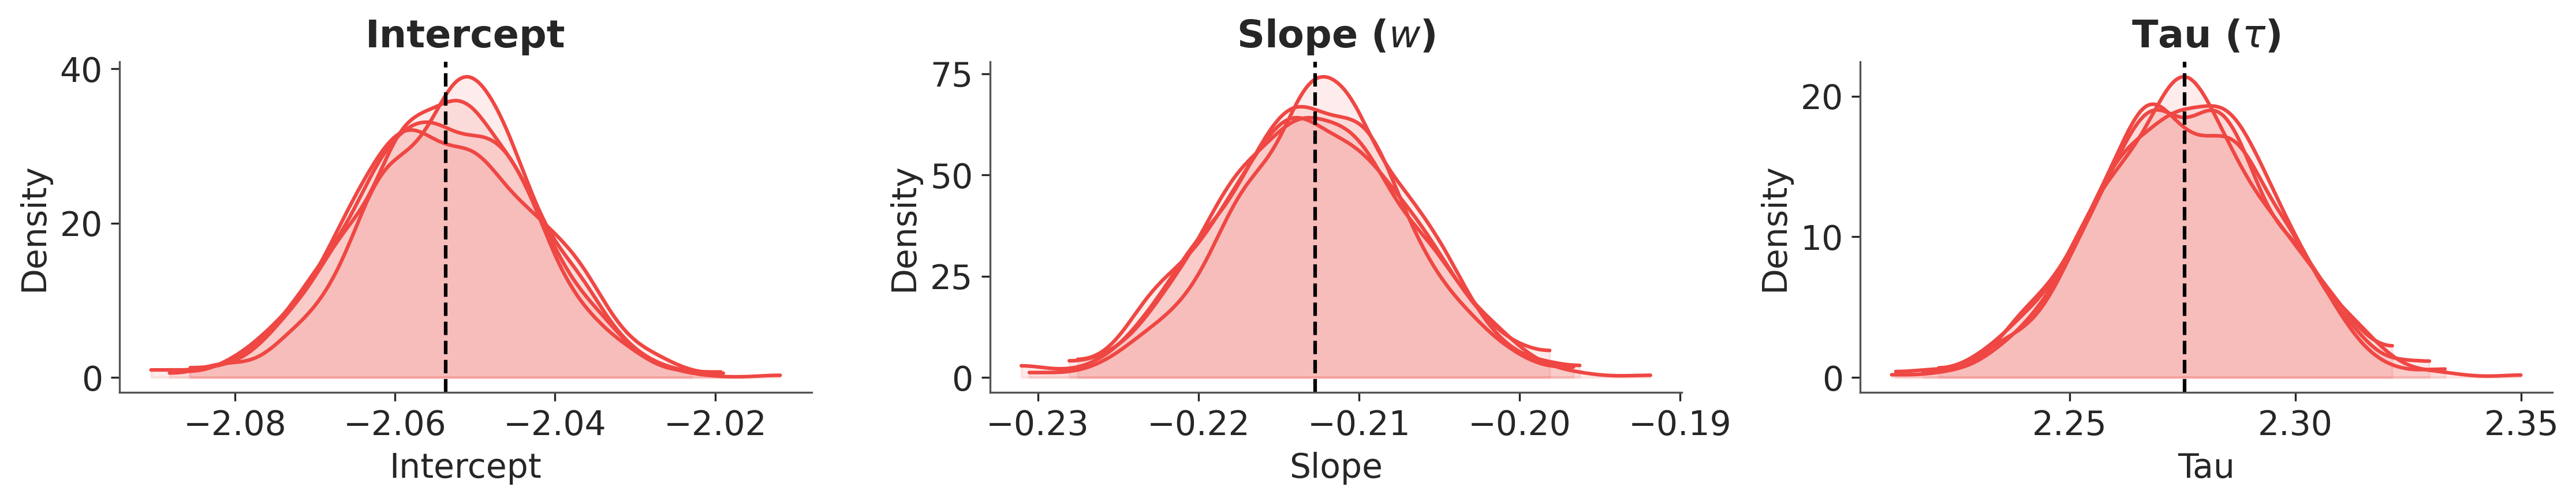

In [40]:
variables = ["intercept", "slope", "kappa"]
titles = ["Intercept", "Slope ($w$)", "Tau ($\\tau$)"]
x_labels = ["Intercept", "Slope", "Tau"]

fig, ax = plt.subplots(1, 3, figsize=(15, 3), dpi=300)
for i, var in enumerate(variables):

    data = incorrect_trace.posterior[var].values
    
    for j in range(4):
        az.plot_dist(data[j], color="#EF4743", fill_kwargs={"alpha": 0.1}, ax=ax[i])

    # plot a center mean line
    ax[i].axvline(data.mean(), color="k", linestyle="--")

    ax[i].set_xlabel(x_labels[i])
    ax[i].set_ylabel("Density")
    ax[i].set_title(titles[i])

plt.tight_layout()


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

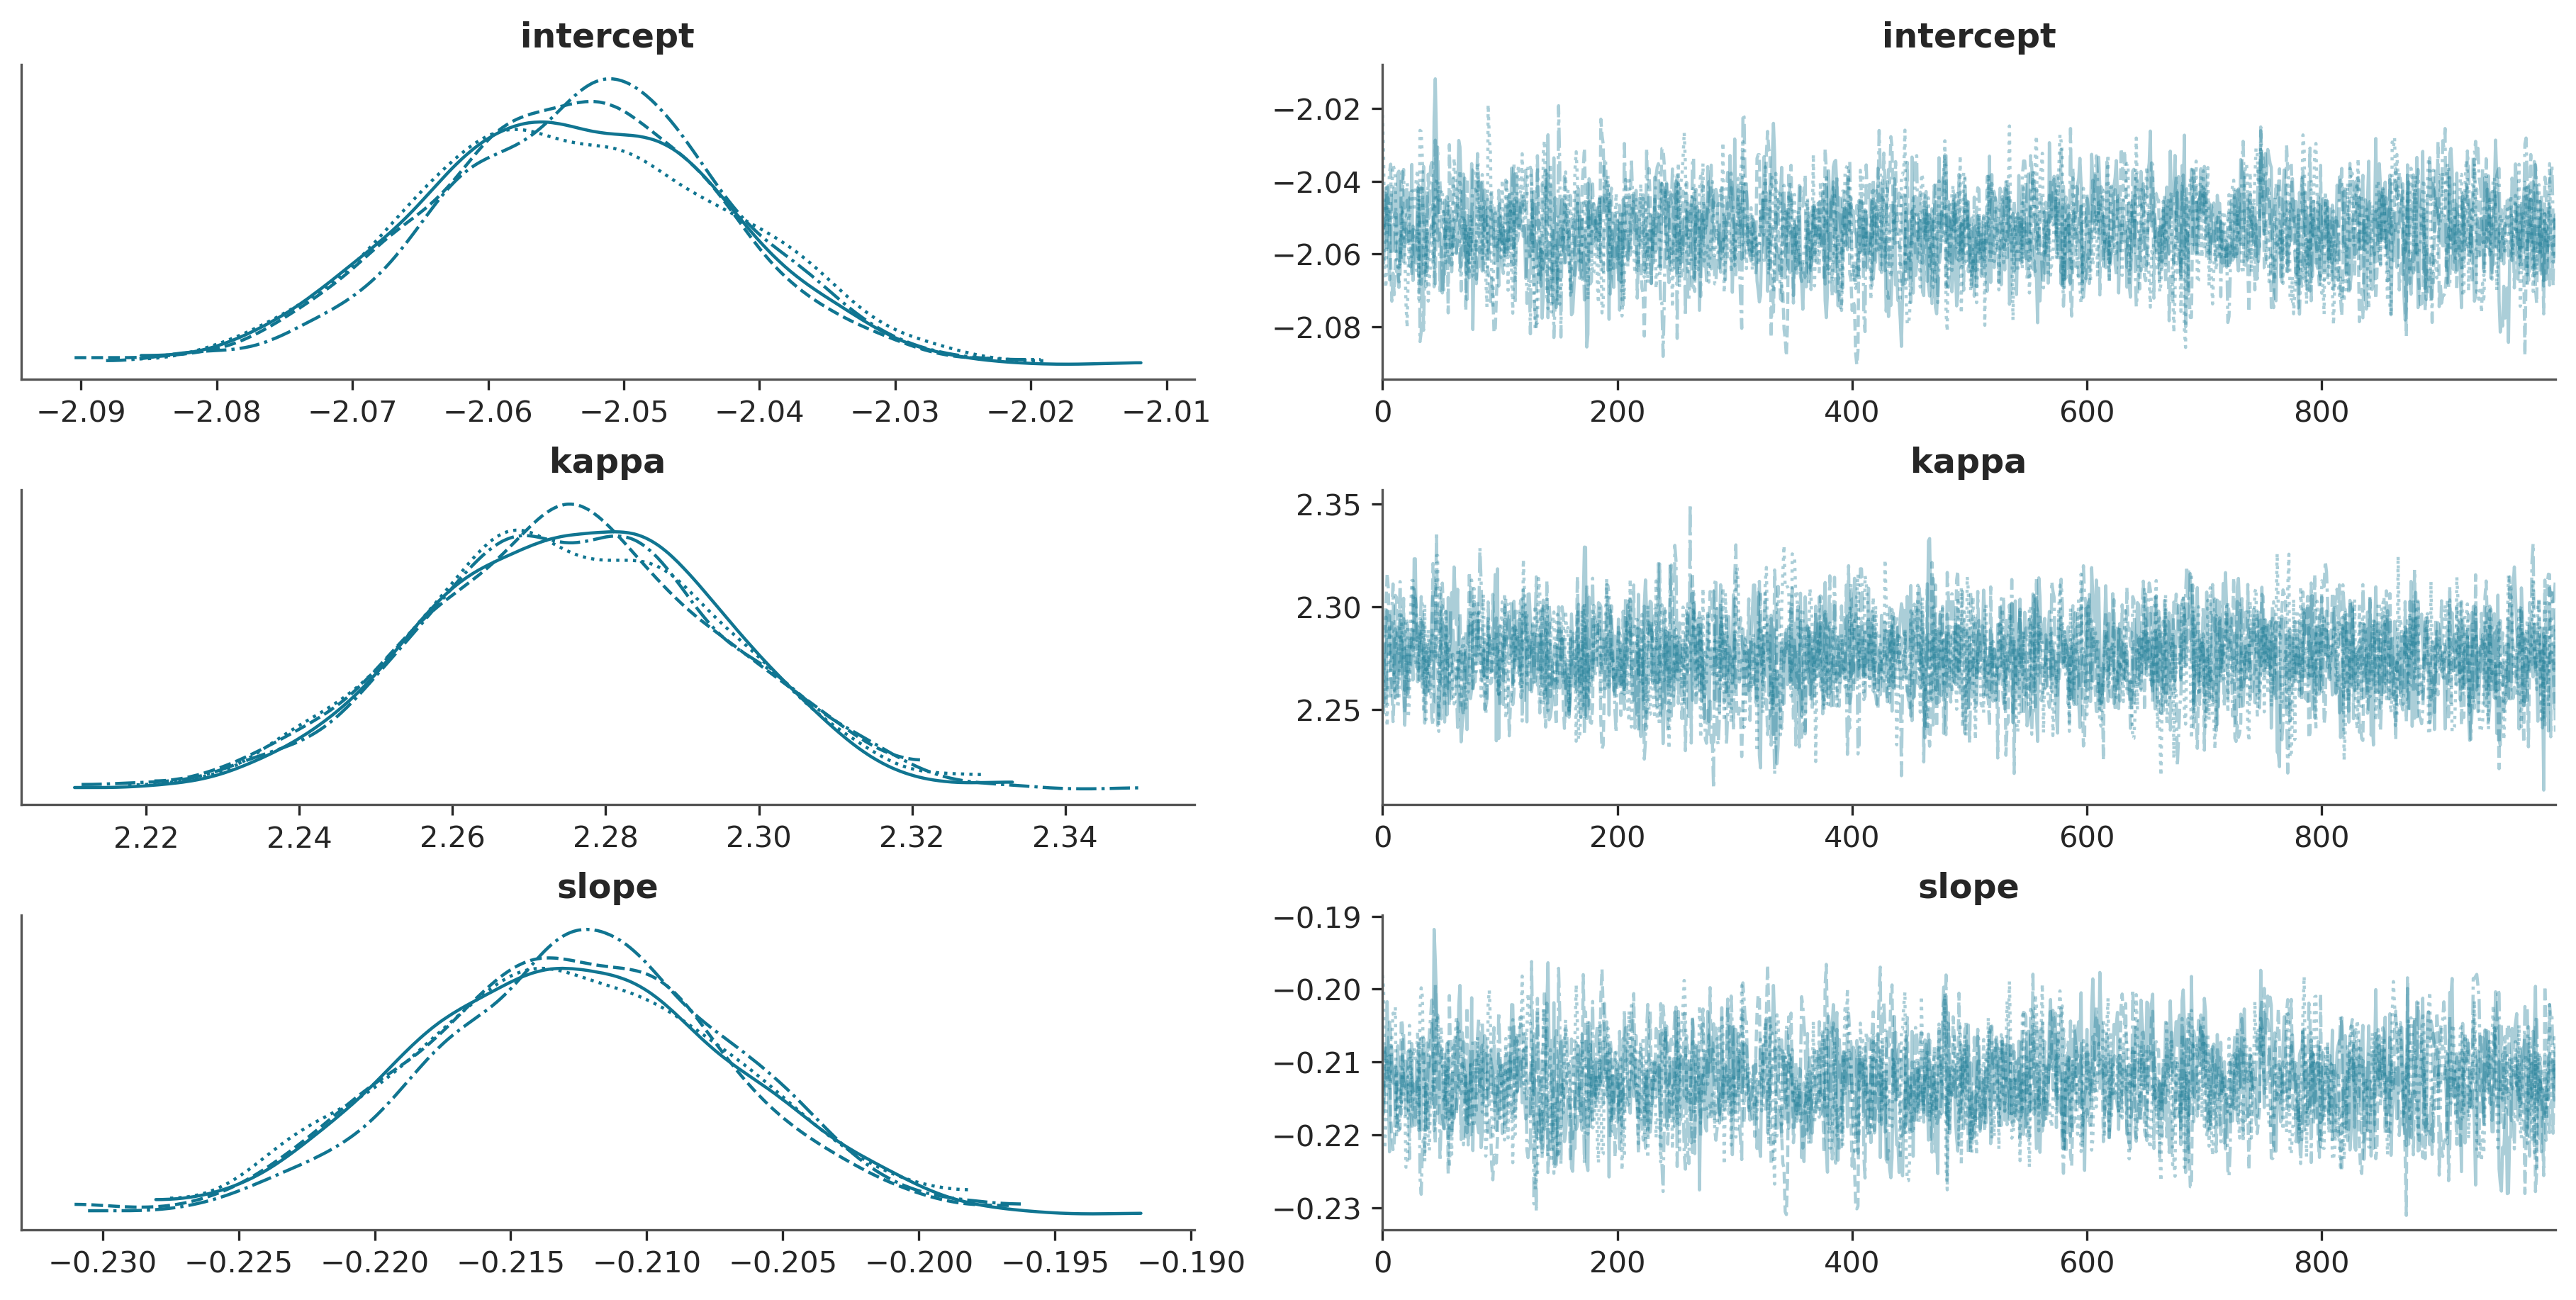

In [27]:

az.plot_trace(incorrect_trace, plot_kwargs={"color": "k", "alpha": 1})
# plt.tight_layout()

In [28]:
az.summary(incorrect_trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -2.054  0.011  -2.074   -2.034        0.0      0.0    1781.0   
kappa      2.275  0.019   2.239    2.311        0.0      0.0    2551.0   
slope     -0.213  0.006  -0.223   -0.202        0.0      0.0    1732.0   

           ess_tail  r_hat  
intercept    1885.0    1.0  
kappa        2306.0    1.0  
slope        1876.0    1.0

In [29]:
az.summary(correct_trace)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  -1.080   0.986  -2.093   -0.088      0.491    0.376       6.0   
kappa      16.568  15.592   0.944   32.574      7.764    5.945       6.0   
slope      -0.644   1.594  -2.251    0.953      0.794    0.608       6.0   

           ess_tail  r_hat  
intercept     139.0   1.73  
kappa         145.0   1.73  
slope         154.0   1.73

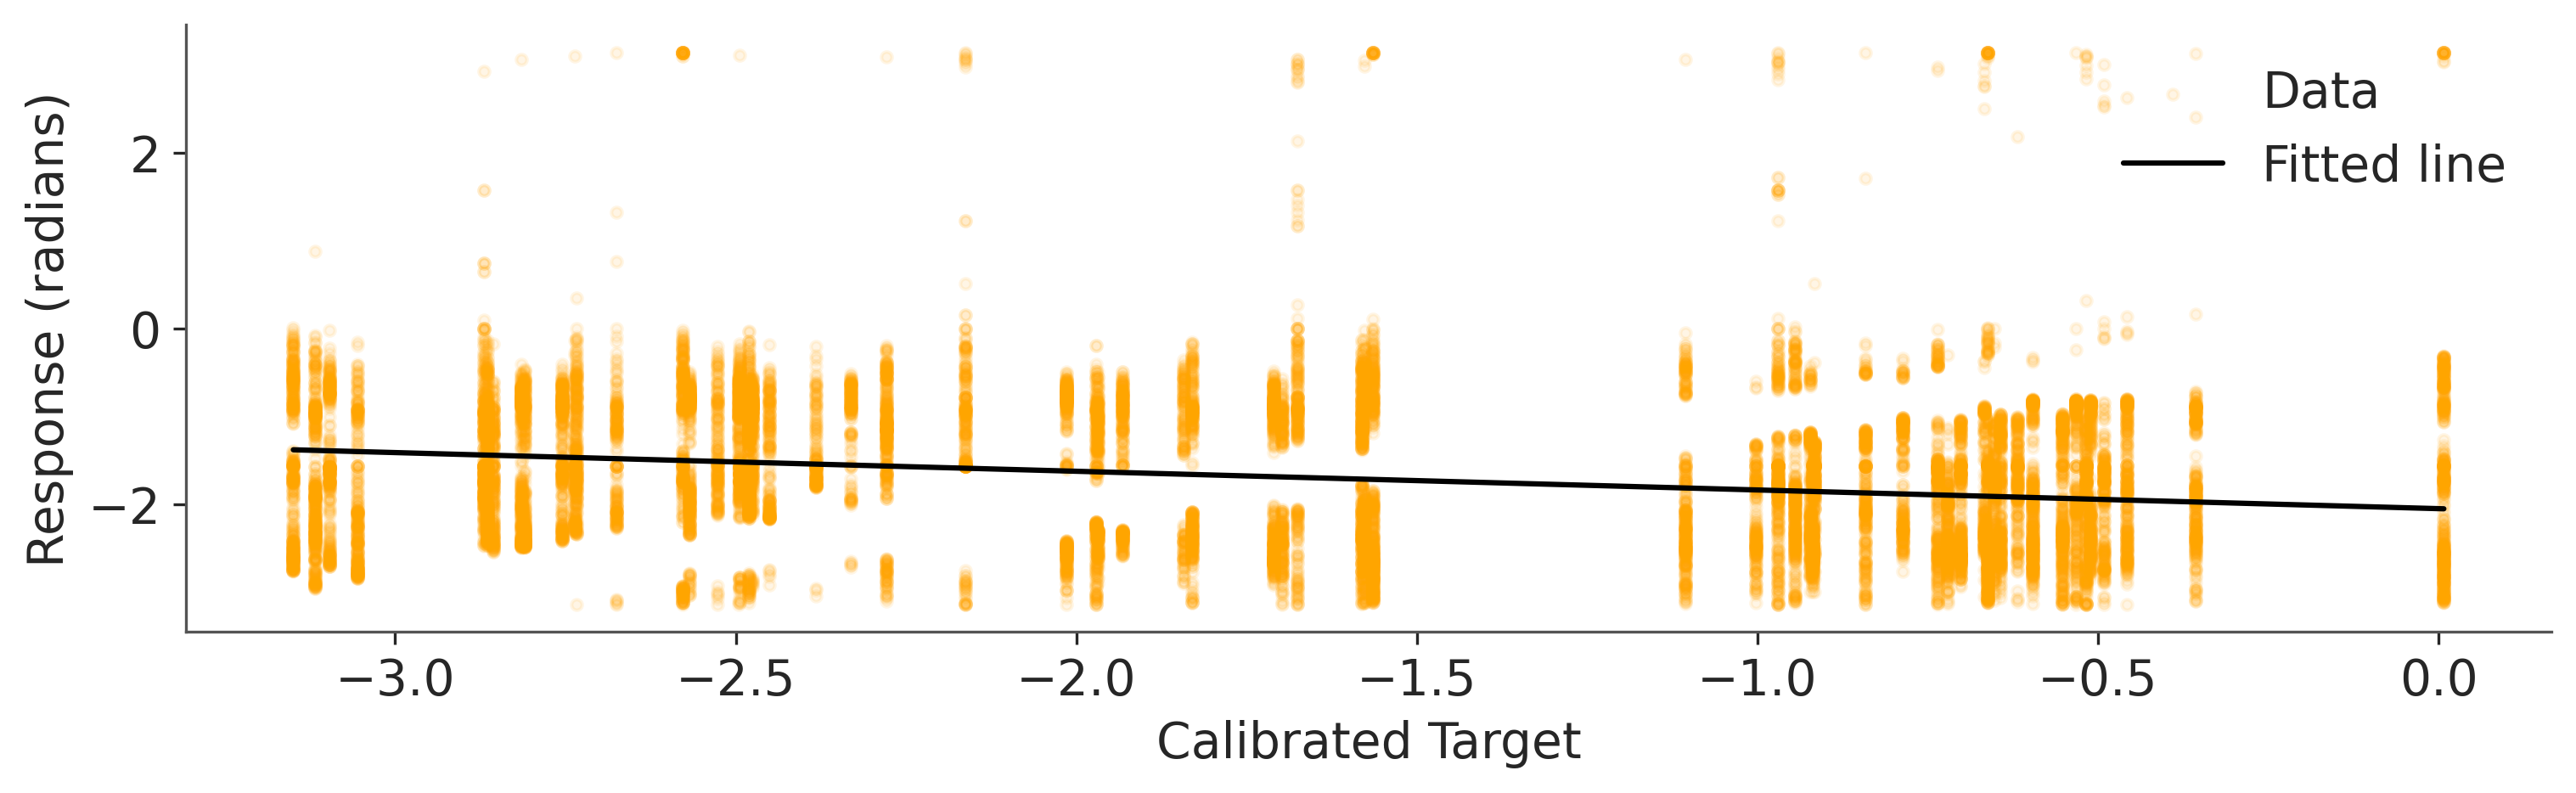

In [30]:
x = i_x
y = i_y

x_values = np.linspace(x.min(), x.max(), 100)
y_values = incorrect_trace.posterior["intercept"].mean().values + incorrect_trace.posterior["slope"].mean().values * x_values

plt.figure(figsize=(10, 3), dpi=300)
plt.scatter(x, y, label="Data", alpha=0.1, marker=".", c="orange")
plt.plot(x_values, y_values, label="Fitted line", color="k")

plt.xlabel("Calibrated Target")
plt.ylabel("Response (radians)")
plt.legend(loc="upper right")
plt.show()


In [68]:
# Given the mu and kappa, plot a von mises distribution

def plot_vm(mu, kappa, color, label):
    x = np.linspace(-np.pi, np.pi, 1000)
    y = np.exp(kappa * np.cos(x - mu)) / (2 * np.pi * np.i0(kappa))
    plt.plot(x, y, color=color, label=label)
    plt.fill_between(x, y, color=color, alpha=0.4)
    plt.xlim(-np.pi, np.pi)
    plt.ylim(0, 1)
    plt.xlabel("Angle (radians)")
    plt.ylabel("Probability density")
    plt.title("Emission Models' Distributions at (x = 1)")


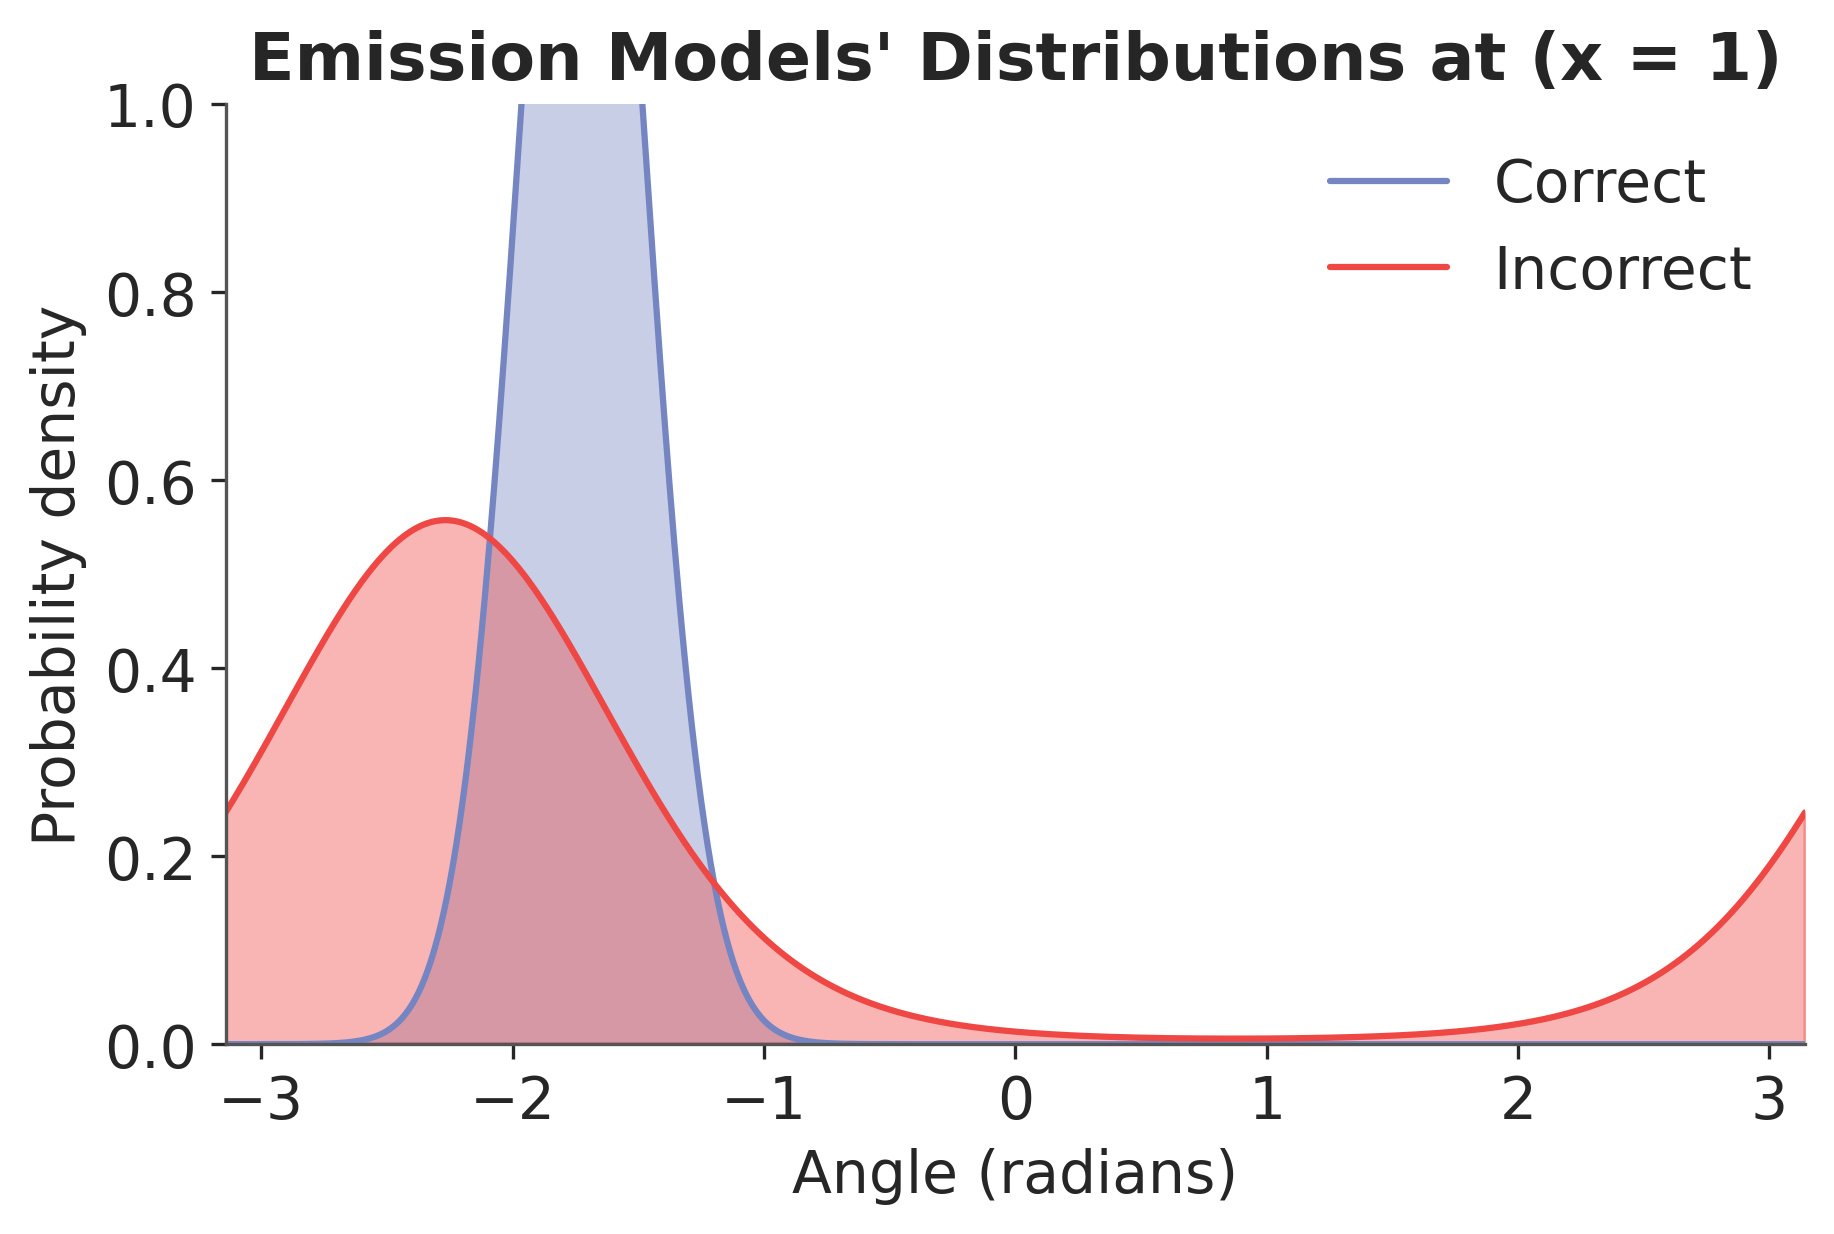

In [70]:
fig = plt.figure(figsize=(6, 4), dpi=300)
# Incorrect
# Correct
plot_vm(-0.644 -1.080, 16.568, "#7485C2", "Correct")
plot_vm(-0.213 -2.054, 2.275, "#EF4743", "Incorrect")

plt.legend()

# # put correct and incorrect in the legend
# plt.legend(["Incorrect", "Correct"])
# # make the legend use the same color as the plot
# plt.legend(["Incorrect", "Correct"], facecolor='white')